In [1]:
# %load_ext autoreload
# %autoreload 2

The autoreload module is not an IPython extension.


UsageError: Line magic function `%autoreload` not found.


In [25]:
import sys, os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad

# from IPython.display import Audio
# tada = 'C://Users/stephanies/tada.mp3'

from celltype_mapping import TangramMapping, bin_gene_table, convert_to_anndata

In [7]:
# set paths for data

# base network data path
data_path = '//allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial'

# save path
out_path = data_path + '/BGI/cDNAD5'

# spatial AnnData file
sp_anndata_file = out_path + '/macaque-cDNA5-bin100.h5ad'

# single cell AnnData file
sc_anndata_file = data_path + '/snRNAseq_data/macaque/macaque_MTG_raw.h5ad'

# bulkseq file
bulk_file  = data_path + '/bulkseq/macaque/QM22.26.030.MTG_abundance.tab'

# path for storing tangram mapping
tg_mapping_path = out_path + '/mapping'

If you already have data saved out TangramMapping class can be instantiated from those files

In [14]:
tg_map = TangramMapping(
    sc_data=sc_anndata_file, 
    sp_data=sp_anndata_file, 
    )

Select your training genes for Tangram

In [17]:
## select marker genes

neuron_marker_genes = pd.read_csv(data_path + '/snRNAseq_data/macaque/macaque_subclass_roc_markers.csv')
print(f'subclass marker genes: {len(neuron_marker_genes)}')
glia_marker_genes = pd.read_csv(data_path + '/snRNAseq_data/macaque/macaque_glia_roc_markers.csv')
print(f'glial marker genes: {len(glia_marker_genes)}')
marker_genes_df = neuron_marker_genes.append(glia_marker_genes)
marker_genes = marker_genes_df['gene'].to_list()
print(f'total marker genes: {len(marker_genes)}')

subclass marker genes: 1856
glial marker genes: 1781
total marker genes: 3637


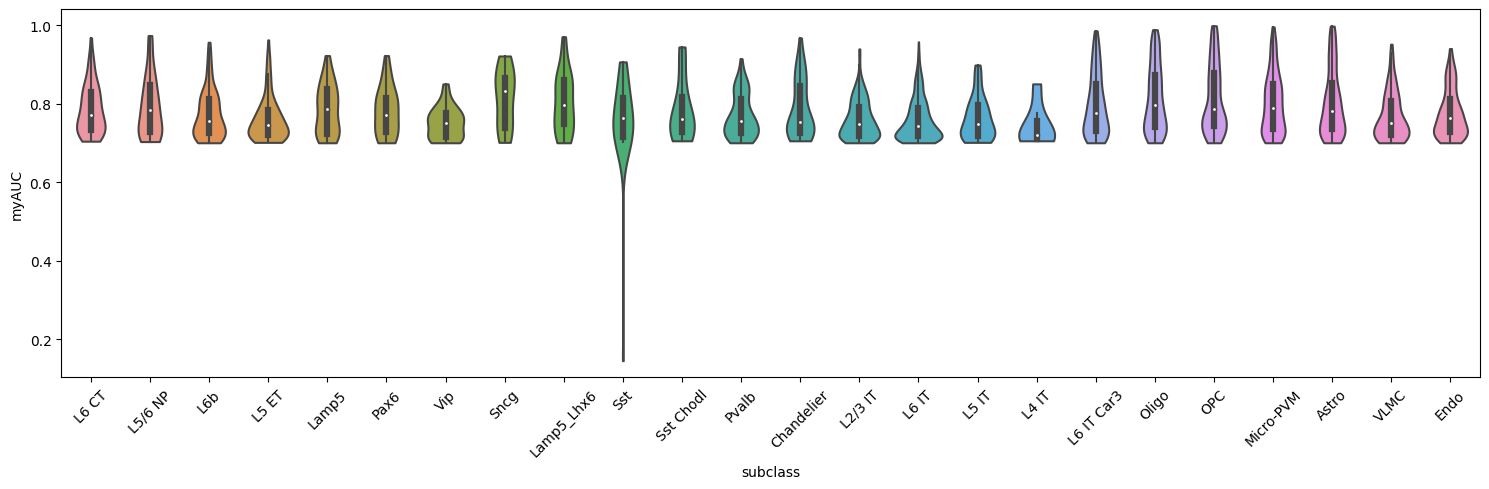

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(data=marker_genes_df, x='cluster', y='myAUC', ax=ax, cut=0)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_xlabel('subclass')
plt.tight_layout()

In [19]:
# reduce to marker genes above median
marker_medians = marker_genes_df.groupby('cluster').median()
marker_genes_reduced = None
for cluster in marker_genes_df['cluster'].unique():
    thresh = marker_medians.loc[cluster]['myAUC']
    gene_filter = marker_genes_df[(marker_genes_df['cluster']==cluster) & (marker_genes_df['myAUC']>thresh)]
    if marker_genes_reduced is None:
        marker_genes_reduced = gene_filter
    else:
        marker_genes_reduced = marker_genes_reduced.append(gene_filter)
        
gene_list = marker_genes_reduced['gene'].tolist()

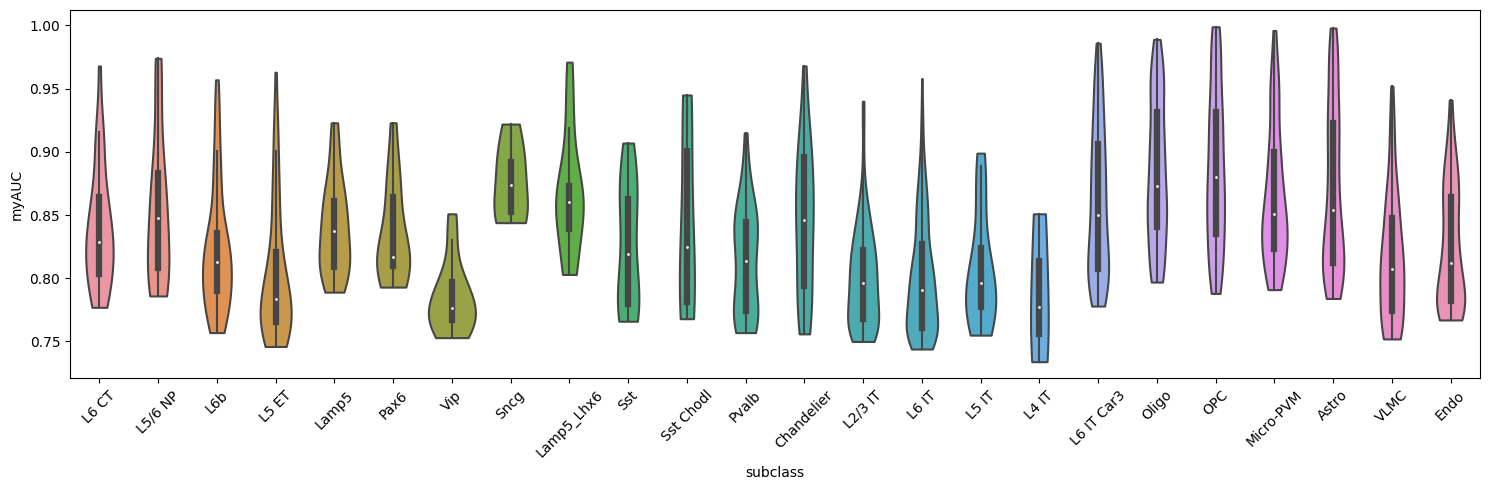

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(data=marker_genes_reduced, x='cluster', y='myAUC', ax=ax, cut=0)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_xlabel('subclass')
plt.tight_layout()

In [21]:
tg_map.set_training_genes(gene_list, meta={'training_genes': 'subclass RNAseq markers above median ROC'})
# Audio(tada, autoplay=True)

starting with 1809 training genes..


INFO:root:1294 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14161 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


NameError: name 'Audio' is not defined

In [22]:
# run mapping with default settings:
# device='cpu', mode='clusters', cluster_label='subclass'

tg_map.mapping(cluster_label='subclass')
# Audio(tada, autoplay=True)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1294 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.307, KL reg: 0.264
Score: 0.420, KL reg: 0.001
Score: 0.422, KL reg: 0.001
Score: 0.423, KL reg: 0.001
Score: 0.423, KL reg: 0.001
Score: 0.423, KL reg: 0.001
Score: 0.423, KL reg: 0.001
Score: 0.424, KL reg: 0.001
Score: 0.424, KL reg: 0.001
Score: 0.424, KL reg: 0.001


INFO:root:Saving results..


In [23]:
tg_map.meta

{'training_genes': 'subclass RNAseq markers above median ROC',
 'mode': 'clusters',
 'cluster_label': 'subclass'}

In [26]:
if not os.path.exists(tg_mapping_path):
    os.mkdir(tg_mapping_path)
tg_map.save_mapping(save_path=tg_mapping_path)

analysis UID: 1673987067.136


Running core analysis set..
1) plot training scores of mapping
2) plot mapping probability at each spatial position for each cluster label


INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


3) get and plot the maximum cluster label for each spatial position
4) predict spatial gene expression, plot canonical markers and histogram of scores
           score  is_training  sparsity_sp  sparsity_sc  sparsity_diff
mog     0.729917         True     0.511103     0.914507      -0.403404
opalin  0.633752         True     0.688710     0.939011      -0.250301
cux2    0.582063         True     0.778468     0.524233       0.254235
lamp5   0.548940         True     0.810945     0.865741      -0.054796
grik1   0.538461         True     0.733934     0.335638       0.398296
gfap    0.510789        False     0.218812     0.973044      -0.754231
rorb    0.495601         True     0.880364     0.620701       0.259663
pvalb   0.429323        False     0.842772     0.937685      -0.094913
fezf2   0.413227         True     0.913328     0.925061      -0.011733
lhx6    0.374338         True     0.912840     0.785012       0.127828


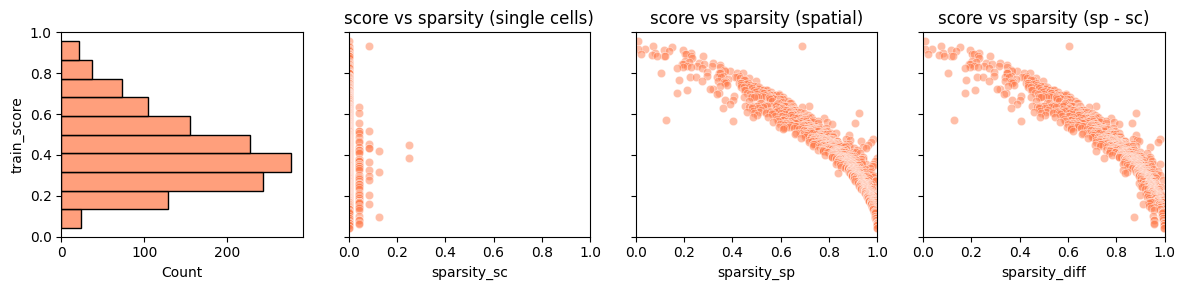

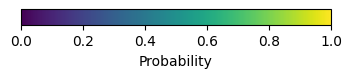

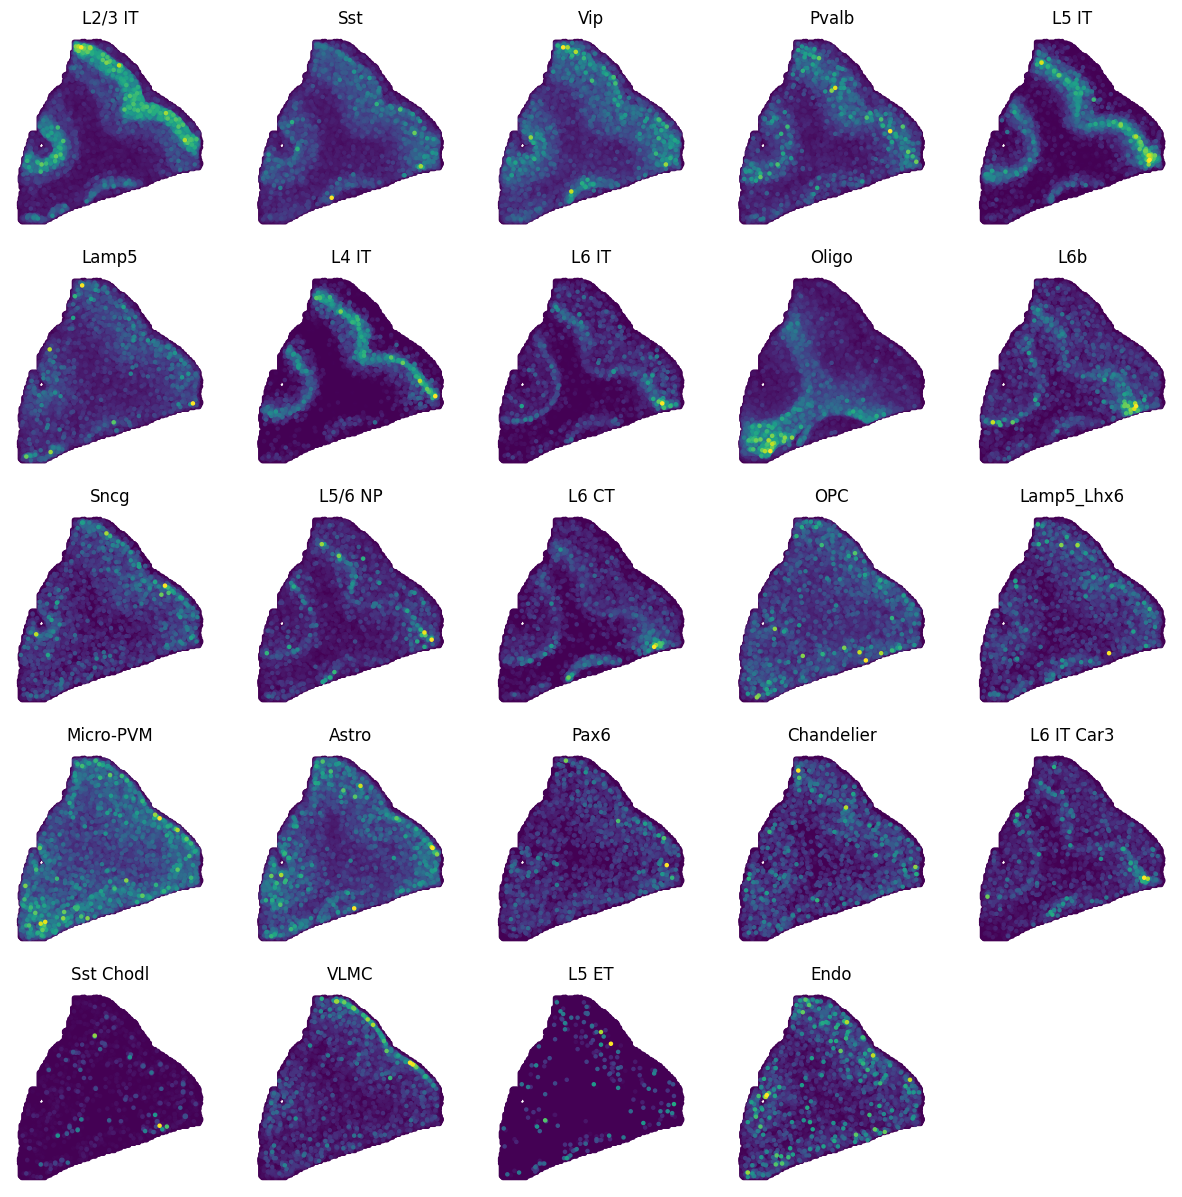

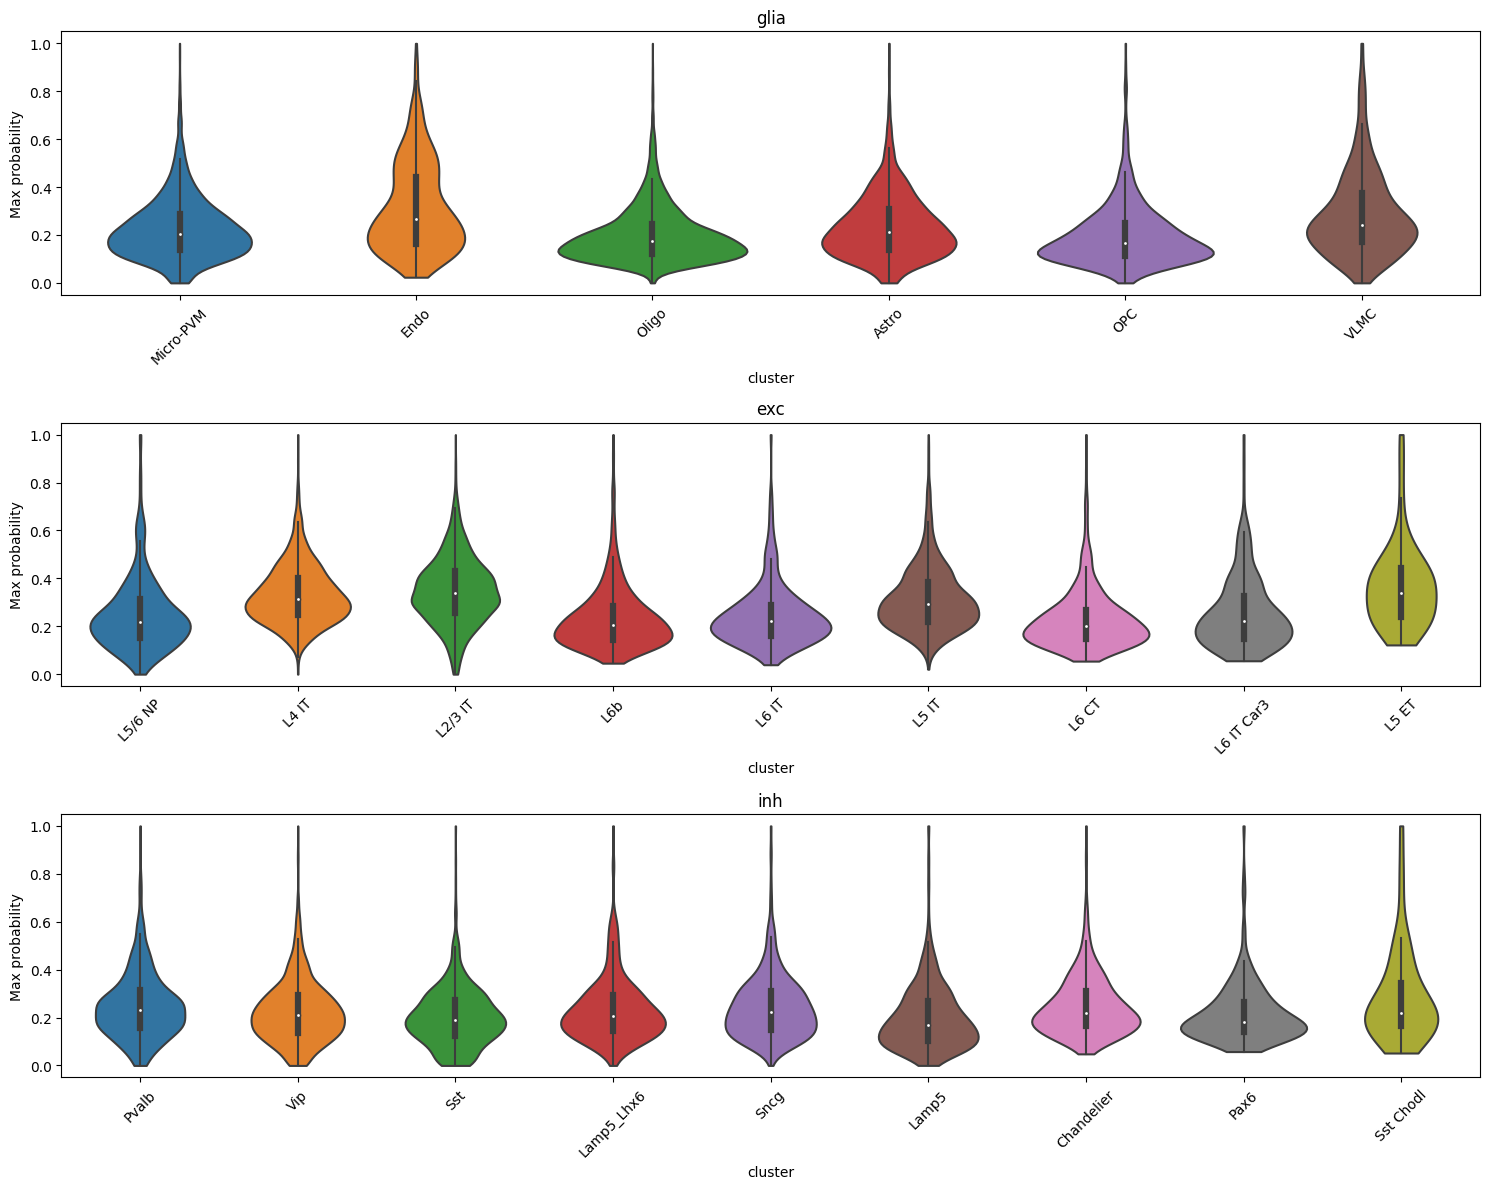

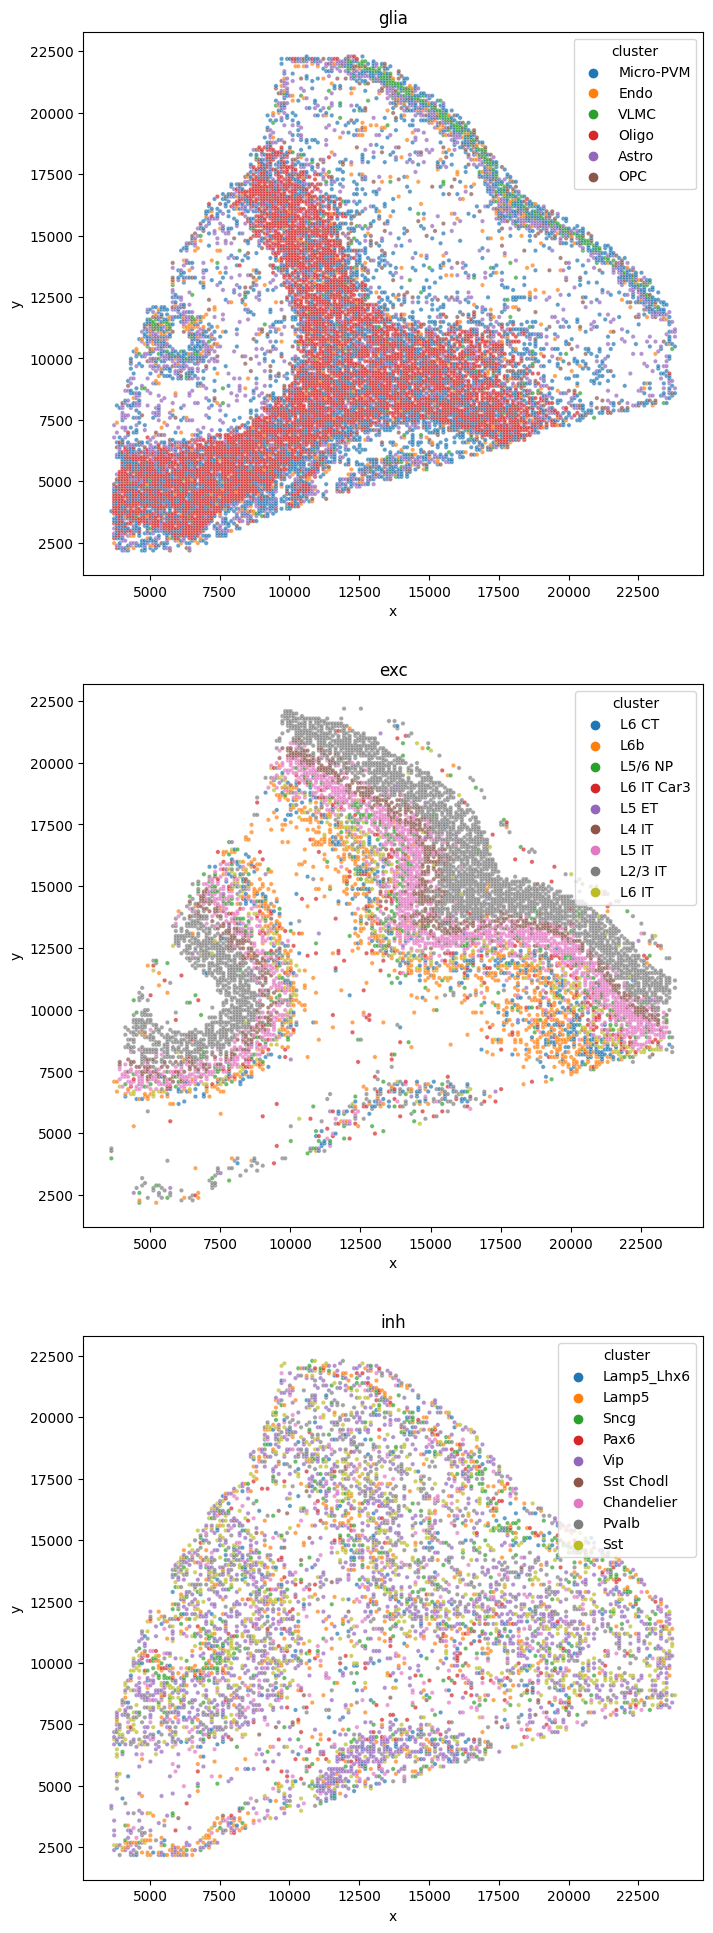

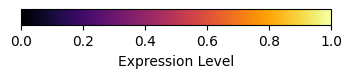

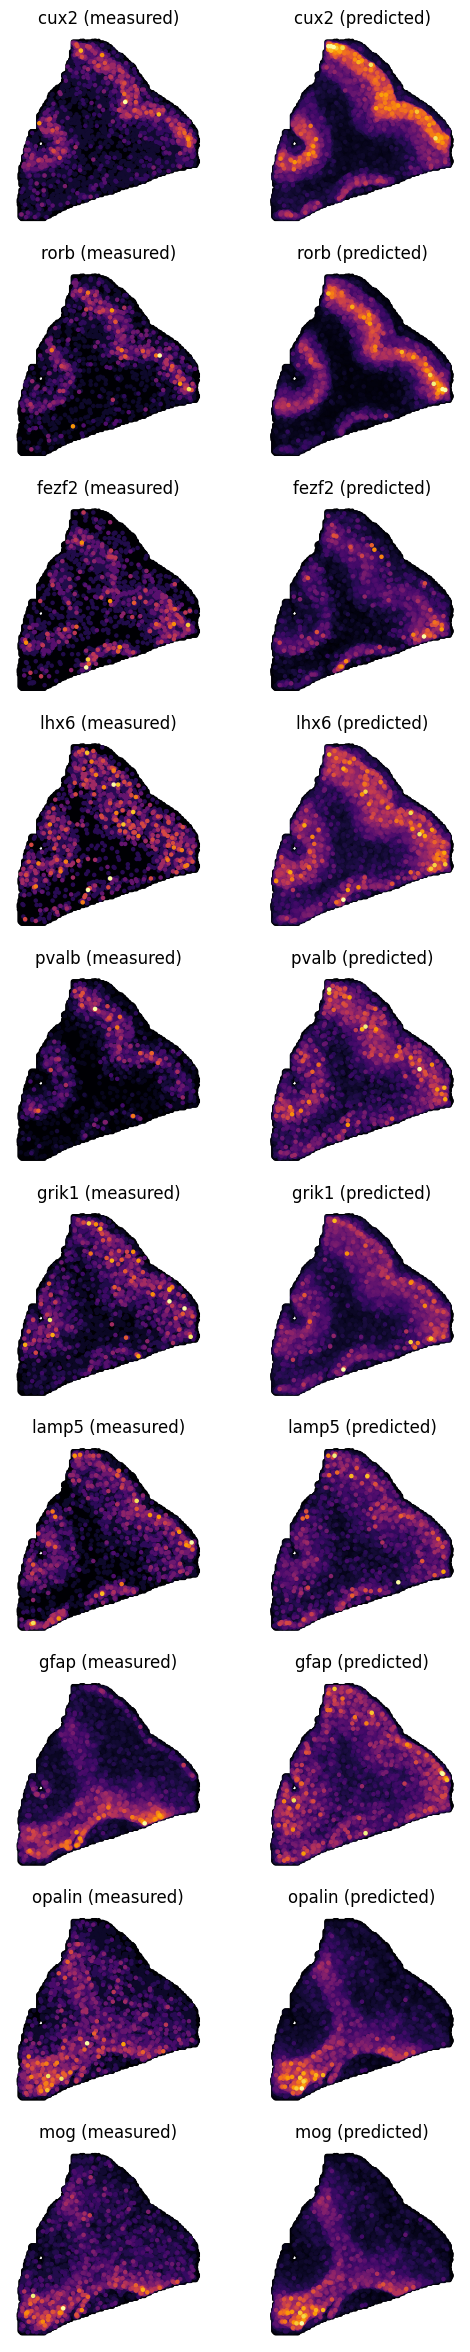

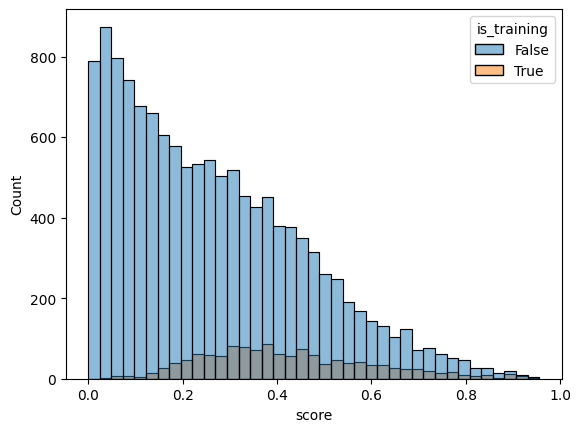

In [27]:
tg_map.evaluate_mapping()

In [72]:
tg_map.save_mapping(save_path=tg_mapping_path, file_name='evaluation', replace=True,)             
Audio(tada, autoplay=True)

analysis UID: 1664576157.125


In [13]:
tg_map.ad_sp.obsm['tangram_ct_pred']

L2/3 IT           Sst           Vip         Pvalb  \
bin:3615_3786    3.725581e-08  7.872044e-09  8.405274e-09  4.163798e-08   
bin:3615_3986    3.237351e-08  3.323902e-08  3.906239e-08  2.518267e-07   
bin:3615_4086    4.485981e-09  1.054721e-07  1.079902e-07  3.866199e-08   
bin:3615_4186    1.041919e-07  1.750761e-07  8.578200e-09  1.925338e-08   
bin:3615_4286    1.697041e-08  7.187172e-08  1.701527e-08  8.728082e-08   
...                       ...           ...           ...           ...   
bin:23815_8786   5.283063e-08  1.870692e-08  1.041449e-08  1.490888e-08   
bin:23815_10486  1.428049e-08  1.115273e-07  6.811283e-08  5.529659e-09   
bin:23815_10886  9.753063e-08  4.014118e-09  5.339888e-08  3.662937e-08   
bin:23815_11086  3.705123e-08  4.182911e-08  2.406527e-08  7.631228e-09   
bin:23815_11186  1.053792e-08  9.793699e-08  2.699072e-08  5.121383e-08   

                        L5 IT         Lamp5         L4 IT         L6 IT  \
bin:3615_3786    1.453331e-08  1.584339e-08  1.616238e-08  1.504944e-08   
bin:3615_3986    4.248404e-08  1.022513e-08  1.318763e-08  2.255372e-08   
bin:3615_4086    1.329917e-08  9.382323e-09  7.340944e-09  1.498809e-07   
bin:3615_4186    5.773414e-09  2.298359e-08  2.480367e-09  1.897492e-08   
bin:3615_4286    1.166215e-08  4.126577e-08  6.346965e-09  5.180256e-09   
...                       ...           ...           ...           ...   
bin:23815_8786   3.155827e-08  9.746964e-08  3.652766e-09  3.740664e-08   
bin:23815_10486  9.515601e-09  1.364978e-08  2.241751e-08  1.395464e-08   
bin:23815_10886  2.795367e-08  9.297528e-09  7.458169e-09  1.066105e-08   
bin:23815_11086  7.065105e-09  1.920033e-07  1.057495e-08  1.414479e-08   
bin:23815_11186  3.900235e-08  2.996048e-08  5.182454e-08  2.627803e-08   

                        Oligo           L6b  ...    Lamp5_Lhx6     Micro-PVM  \
bin:3615_3786    8.178473e-08  1.083157e-08  ...  1.603672e-08  3.161531e-08   
bin:3615_3986    1.924260e-08  6.860684e-08  ...  7.084643e-09  6.534803e-08   
bin:3615_4086    4.864601e-08  3.651275e-08  ...  2.260684e-08  2.566373e-08   
bin:3615_4186    6.095470e-08  2.288569e-08  ...  2.755213e-08  6.526501e-08   
bin:3615_4286    9.242705e-09  7.292501e-09  ...  2.252592e-08  1.963231e-08   
...                       ...           ...  ...           ...           ...   
bin:23815_8786   2.000320e-08  1.359675e-08  ...  5.776431e-09  1.478731e-08   
bin:23815_10486  4.823533e-08  1.708469e-08  ...  3.360132e-08  1.232133e-07   
bin:23815_10886  9.350224e-08  9.748566e-09  ...  4.997457e-08  1.634681e-08   
bin:23815_11086  4.024436e-08  8.544983e-09  ...  3.805158e-08  3.405922e-08   
bin:23815_11186  1.786006e-08  2.789765e-08  ...  9.600488e-09  2.391091e-07   

                        Astro          Pax6    Chandelier    L6 IT Car3  \
bin:3615_3786    8.782106e-08  5.742645e-09  2.706420e-09  1.003017e-07   
bin:3615_3986    4.437311e-08  8.714593e-09  1.020727e-08  1.271168e-08   
bin:3615_4086    2.390923e-08  2.189733e-08  6.911064e-08  1.329646e-08   
bin:3615_4186    2.750734e-08  5.800610e-09  1.058761e-08  2.236999e-08   
bin:3615_4286    3.361410e-08  4.521312e-09  1.107576e-08  7.185648e-09   
...                       ...           ...           ...           ...   
bin:23815_8786   1.198505e-07  1.593393e-08  9.147324e-09  5.150362e-08   
bin:23815_10486  8.923552e-08  1.002717e-08  1.005645e-08  2.032509e-08   
bin:23815_10886  3.651724e-08  3.082651e-08  3.606943e-08  1.209387e-08   
bin:23815_11086  3.376634e-07  8.635090e-09  2.167631e-08  3.042208e-08   
bin:23815_11186  7.226650e-08  3.628003e-08  1.507853e-08  8.722840e-09   

                    Sst Chodl          VLMC         L5 ET          Endo  
bin:3615_3786    1.999329e-08  5.975299e-08  3.352447e-09  6.780684e-08  
bin:3615_3986    1.072434e-08  4.310867e-08  1.308616e-08  5.989260e-08  
bin:3615_4086    4.740282e-08  1.156120e-07  3.858278e-09  3.634319e-08  
bin:3615_4186    1.662428e-08  4.892381e-08  4.972165e-09  6.0

In [37]:
n_types = tg_map.ad_map.X.shape[0]
most_likely_type = tg_map.ad_map.X.argmax(axis=0)

conf_matrix = [[] for i in range(n_types)]
for i in range(tg_map.ad_map.X.shape[1]):
    conf_matrix[most_likely_type[i]].append(tg_map.ad_map.X[:, i])
for i in range(n_types):
    conf_matrix[i] = np.stack(conf_matrix[i], axis=1).sum(axis=1)
    conf_matrix[i] /= conf_matrix[i].sum()
conf_matrix = np.array(conf_matrix)

diff = np.diag(conf_matrix) / conf_matrix.sum(axis=1)

In [22]:
most_likely_type[0]

19

In [24]:
tg_map.ad_map.X[:, 0]

array([3.72558127e-08, 7.87204435e-09, 8.40527381e-09, 4.16379820e-08,
       1.45333088e-08, 1.58433888e-08, 1.61623799e-08, 1.50494408e-08,
       8.17847265e-08, 1.08315685e-08, 4.30907976e-09, 4.77265445e-08,
       1.04114557e-08, 1.61423994e-08, 1.60367222e-08, 3.16153148e-08,
       8.78210571e-08, 5.74264547e-09, 2.70642042e-09, 1.00301705e-07,
       1.99932906e-08, 5.97529919e-08, 3.35244676e-09, 6.78068446e-08],
      dtype=float32)

In [38]:
diff

array([0.2438484 , 0.23723365, 0.250695  , 0.26871124, 0.2888277 ,
       0.27361134, 0.32644296, 0.32331976, 0.32595742, 0.33968583,
       0.3115374 , 0.30923468, 0.32350358, 0.29923353, 0.30582562,
       0.27556202, 0.23772317, 0.35291094, 0.33492893, 0.34016642,
       0.550062  , 0.35167027, 0.7910405 , 0.33137688], dtype=float32)